<a href="https://colab.research.google.com/github/Jasmar9/PerceptronClasificadorCancer/blob/main/PerceptronClasificadorCancerEs%C3%B3fago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clasificador de tejido sano y tejido cancerígeno en imagenes microscópicas del esófago

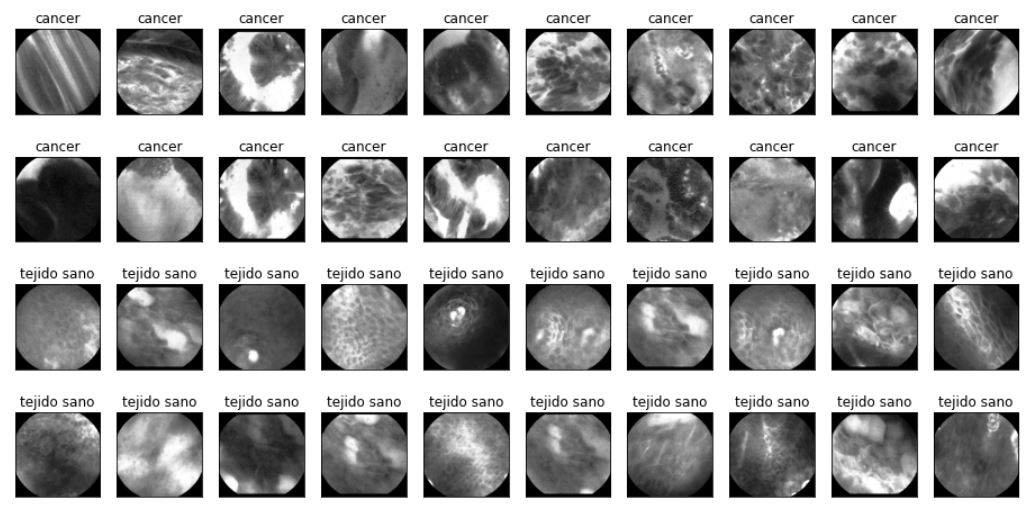

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Colab Notebooks/PerceptronClasificadorCancerEsófago/Cancer esofago.jpg')

## Paso 1. Cargar librerías y módulos requerdidos

In [ ]:
import os            # módulo para manejar carpetas y archivos en nuestro ordenador
import random        # módulo para aleatorizar
import pickle        # módulo para respaldar objetos de pyhton como cadenas de bytes
                     # (serialización de objetos).

import numpy as np   # biblioteca para manejar matrices y operaciones de matrices
import pandas as pd  # biblioteca para manejar tablas de datos

#Skimage (Scikit-image): biblioteca para procesamiento de imágenes
from skimage import io  #Modulo para leer una imagen (librería para procesamiento de imagenes)

#Sklearn (Scikit-learn): biblioteca para machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

#Bibliotecas para gráficar y visualizar
import matplotlib.pyplot as plt
import seaborn as sns

## Paso 2. Lectura de datos.

### 2.1 Lectura de etiquetas (Y)

In [ ]:
#Leemos los datos

datos = pd.read_csv("https://raw.githubusercontent.com/AnIsAsPe/ClassificadorCancerEsofago/master/Datos/ClasesImagenes.csv", usecols=[1,2])


In [ ]:
type(datos)

pandas.core.frame.DataFrame

In [ ]:
datos.head()  #muestra los primeros cinco registros

,image_filename,class_number
0,im_4_0.png,0
1,im_21_0.png,0
2,im_9_0.png,0
3,im_8_0.png,0
4,im_15_0.png,0


In [ ]:
#¿Con cuántas imagenes vamos a trabajar?

datos.shape[0]

5063

In [ ]:
#¿cuántas imagenes tenemos de cada clase?

datos['class_number'].value_counts(sort=False)

0    1469
1    3594
Name: class_number, dtype: int64

Clase 0 corresponde a tejido sano y Clase 1 a tejido Cancerígeno

In [ ]:
Y = datos['class_number']  #Guardamos las etiquetas de las imagenes como serie de pandas


### 2.2 Lectura de imágenes (X)

**Lo primero que tenemos que hacer es descomprimir el archivo zip que guardamos en nuestro dirve**

In [ ]:

!unzip -u "/content/drive/MyDrive/Colab Notebooks/PerceptronClasificadorCancerEsófago/DatosCancer/CarpetaImagenes.zip" -d "/content/drive/MyDrive/Colab Notebooks/PerceptronClasificadorCancerEsófago/DatosCancer/Unzip"


Archive:  /content/drive/MyDrive/Colab Notebooks/PerceptronClasificadorCancerEsófago/DatosCancer/CarpetaImagenes.zip


In [ ]:
datos['image_filename'].head()

0     im_4_0.png
1    im_21_0.png
2     im_9_0.png
3     im_8_0.png
4    im_15_0.png
Name: image_filename, dtype: object

**Vamos a leer la primera imagen, para ello además del nombre de la imagen, necesitamos añadir la ruta del directorio en donde se encuentra dicha imagen.**

In [ ]:
nombre_archivo = 'im_4_0.png'

ruta = '/content/drive/MyDrive/Colab Notebooks/PerceptronClasificadorCancerEsófago/DatosCancer/Unzip/'

imagen = io.imread(ruta  + nombre_archivo, as_gray=True)

In [ ]:
# ¿qué tipo de objeto es imagen?
type(imagen)

numpy.ndarray

In [ ]:
# ¿qué dimensiones tiene imagen?
imagen.shape

(260, 260)

In [ ]:
imagen[180, 170:190]

array([0.22525176, 0.22525176, 0.22525176, 0.22525176, 0.21964078,
       0.21738588, 0.21738588, 0.21738588, 0.21738588, 0.21738588,
       0.21738588, 0.21738588, 0.21738588, 0.21429765, 0.21429765,
       0.21964078, 0.23142824, 0.23929412, 0.23142824, 0.23142824])

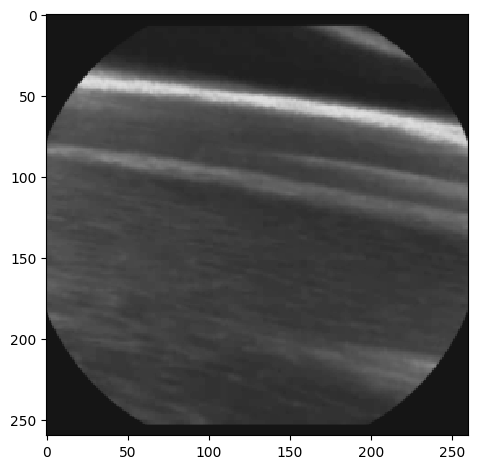

In [ ]:
io.imshow(imagen)

**Ahora vamos a hacer lo mismo para todas las imagenes**

In [ ]:
datos['image_filename']

0          im_4_0.png
1         im_21_0.png
2          im_9_0.png
3          im_8_0.png
4         im_15_0.png
            ...      
5058    im_114_55.png
5059      im_7_55.png
5060     im_52_55.png
5061     im_10_55.png
5062    im_111_55.png
Name: image_filename, Length: 5063, dtype: object

Con esta función vamos a leer todas las imágenes utilizando la ruta en donde se encuentran y el nombre del archivo. Todas las imágenes se leen en blanco y negro y se guardan en el objeto img

In [ ]:
%time  img = datos['image_filename'].apply(lambda x: io.imread(ruta + x, as_gray=True))

CPU times: user 52.4 s, sys: 18 s, total: 1min 10s
Wall time: 22min 18s


<h2>Respaldamos el objeto img en un archivo pickle.<h2>

(si quieres conocer más sobre pickles de python, revisa [este enlace](https://programacion.net/articulo/los_pickles_de_python_1860))

In [ ]:
# Guardar en archivo pickle
ruta2 = '/content/drive/MyDrive/Colab Notebooks/PerceptronClasificadorCancerEsófago/DatosCancer/' # directorio donde se guardará el
pickle.dump(img, open (ruta2 + "imagenes_numpy.pkl", 'wb'))

In [ ]:
# Leer archivo pickle
ruta2 = '/content/drive/MyDrive/Colab Notebooks/PerceptronClasificadorCancerEsófago/DatosCancer/'
img = pickle.load(open(ruta2 + "imagenes_numpy.pkl", 'rb'))

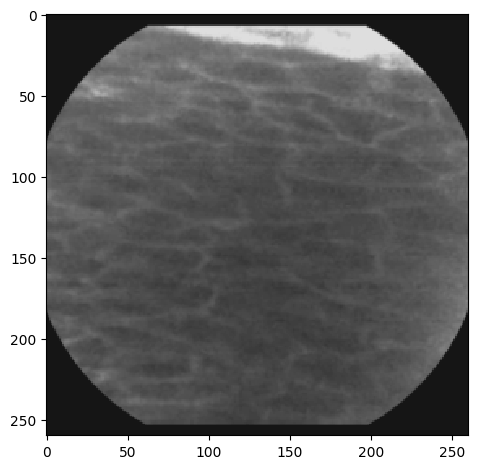

In [ ]:
io.imshow(img[18])

- Dimensión 0: 260 renglones de pixeles de arriba a abajo
- Dimensión 1: 260 columnas de pixeles de izquierda a derecha


####  Transformar imágenes en vectores
Lo primero es transformar la secuencia de matrices img en una sola matriz


In [ ]:
img.shape

(5063,)

In [ ]:
img[0].shape

(260, 260)

##### np.stack()

La función np.stack() se utiliza para unir un conjunto de arrays a lo largo de un nuevo eje. Esta función crea un nuevo array de mayor dimensión a partir de los arrays proporcionados.

Aquí tienes un ejemplo de cómo usar np.stack():

In [ ]:
import numpy as np

# Crear dos arrays 1D
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

# Apilar los arrays a lo largo de un nuevo eje
c = np.stack((a, b), axis=0)

print(c)

print(c.shape)

En este ejemplo, hemos apilado dos arrays 1D a lo largo del eje 0, lo que crea un array 2D. Puedes cambiar el valor del parámetro axis para controlar a lo largo de qué eje se realizará la unión. Por ejemplo, si usas axis=1, el resultado será:

In [ ]:
c = np.stack((a, b), axis=1)

print(c)

print(c.shape)

Ten en cuenta que todos los arrays que desees apilar deben tener la misma forma, excepto en la dimensión correspondiente al eje a lo largo del cual se apilan.

#### Continúa...

In [ ]:
IMG = np.stack(img, axis=0)  # Toma una secuencia de matrices y las apila a lo largo
                              # de un tercer eje para hacer una solo arreglo
IMG.shape

(5063, 260, 260)

Despues aplanar la matriz de 2D (260x260 pixeles) de cada imagen, para obtener un vector por imagen.

La función reshape() se utiliza para cambiar la forma de un array NumPy sin alterar los datos en sí. Al aplicar resultado.reshape(5063, -1) en el array resultado de dimensiones (5063, 260, 260), estás cambiando la forma del array de tres dimensiones a un array de dos dimensiones.

En este caso, el primer argumento de reshape() es 5063, lo que significa que quieres mantener 5063 filas en el array resultante. El segundo argumento es -1, que es un comodín que indica a NumPy que calcule automáticamente el tamaño de la segunda dimensión, de modo que el número total de elementos en el array se mantenga igual.

Obtendrás un array de dimensiones (5063, 67600). El número 67600 se calcula automáticamente como el producto de las dimensiones originales 260x260 (260 * 260 = 67600).

En este array de dos dimensiones, cada fila representa una matriz original de 260x260, pero aplanada en una sola fila de 67600 elementos.

In [ ]:
X = IMG.reshape( 5063, -1)
X.shape

(5063, 67600)

##### Visualizamos ejemplos de ambas clases de imagenes

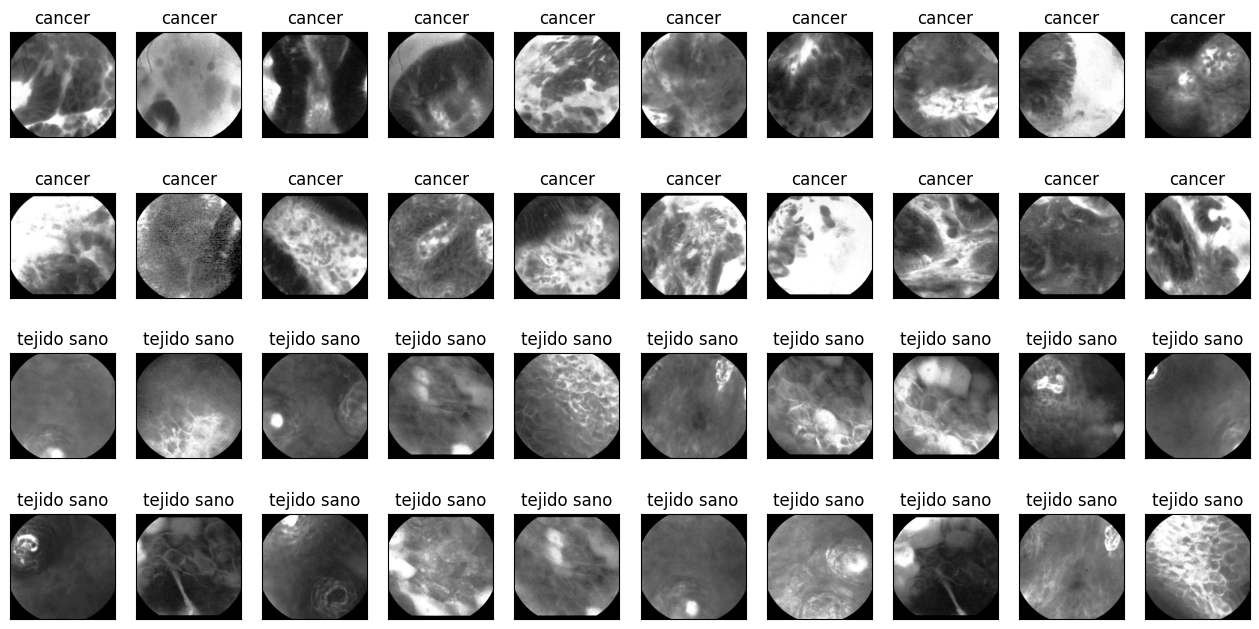

In [ ]:
#El método GroupBy de Pandas separa un data frame en varios data frames
porClase = datos.groupby('class_number')

#elije al azar n muestras de cada subconjunto y guarda la posición de las figuras elegidas en una lista
n = 20
c = random.sample(porClase.get_group(1).index.tolist(), n) # indices de las imagenes cancerígenas seleccionadas
s = random.sample(porClase.get_group(0).index.tolist(), n) # indices de las imagenes sanas seleccionadas

# Grafica 20 imágenes aleatorias de tejido con cáncer y 20 de tejido sano

fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 4
for i in range(0, columns * rows):
    fig.add_subplot( rows, columns, i+1)
    if i < 20:
        plt.imshow(img[c[i]], cmap='Greys_r')
        plt.title('cancer')
        plt.xticks([])
        plt.yticks([])
    else:
        plt.imshow(img[s[i-20]], cmap='Greys_r')
        plt.title('tejido sano')
        plt.xticks([])
        plt.yticks([])
plt.show()

## Paso 3. Entrenamiento utilizando perceptrón simple con conjunto de entrenamiento y prueba

### 3.1  Crear subconjuntos de entrenamiento y prueba



In [ ]:
Y.tail()

5058    1
5059    1
5060    1
5061    1
5062    1
Name: class_number, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3,
                                                    shuffle=True, random_state=0)

In [ ]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Training set")
print("X: ", X_train.shape)
print("Y: ", y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('Tejido Sano:        ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')


print("Test set")
print("X: ", X_test.shape)
print("Y: ", y_test.shape)
unique, counts = np.unique(y_test, return_counts=True)
print('Tejido Sano:         ', counts[0],'\nDisplasia o Cáncer: ', counts[1],'\n')

Training set
X:  (3544, 67600)
Y:  (3544,)
Tejido Sano:         1043 
Displasia o Cáncer:  2501 

Test set
X:  (1519, 67600)
Y:  (1519,)
Tejido Sano:          426 
Displasia o Cáncer:  1093 



### 3.2  Entrenamiento



In [ ]:
model = Perceptron(max_iter=46,   random_state=0, verbose=True)
model.fit(X_train,y_train)

print("Iterations: ", model.n_iter_)

-- Epoch 1
Norm: 1123.26, NNZs: 67600, Bias: -39.000000, T: 3544, Avg. loss: 1641.286726
Total training time: 0.79 seconds.
-- Epoch 2
Norm: 1709.08, NNZs: 67600, Bias: -56.000000, T: 7088, Avg. loss: 1415.700003
Total training time: 1.50 seconds.
-- Epoch 3
Norm: 2155.80, NNZs: 67600, Bias: -69.000000, T: 10632, Avg. loss: 1231.936834
Total training time: 2.16 seconds.
-- Epoch 4
Norm: 2616.13, NNZs: 67600, Bias: -76.000000, T: 14176, Avg. loss: 1124.851144
Total training time: 2.77 seconds.
-- Epoch 5
Norm: 3021.59, NNZs: 67600, Bias: -75.000000, T: 17720, Avg. loss: 1133.721658
Total training time: 3.50 seconds.
-- Epoch 6
Norm: 3379.11, NNZs: 67600, Bias: -74.000000, T: 21264, Avg. loss: 971.851823
Total training time: 4.15 seconds.
-- Epoch 7
Norm: 3724.07, NNZs: 67600, Bias: -66.000000, T: 24808, Avg. loss: 937.594908
Total training time: 4.78 seconds.
-- Epoch 8
Norm: 4026.70, NNZs: 67600, Bias: -68.000000, T: 28352, Avg. loss: 855.373414
Total training time: 5.61 seconds.
-- Ep

In [ ]:
#Guardamos los coeficientes del modelo como beta

beta = model.coef_
print(beta.shape)

(1, 67600)


El atributo model.intercept_ en Scikit-learn es un atributo del modelo que representa el término de sesgo (bias) o intercepción en un modelo lineal. En el caso de un objeto Perceptron, model.intercept_ corresponde al término de sesgo del modelo Perceptrón entrenado.

In [ ]:
model.intercept_


array([-42.])

In [ ]:
beta[0, 5000:5100]

array([  25.98791765,   12.38619333,   -8.74001725,  -17.77721922,
          4.60175765,   43.09832392,   49.66169176,   36.93304353,
         36.66157255,   36.6330149 ,   34.85185922,   26.18636235,
         38.12505608,   19.71102235,   20.78874118,   10.56904588,
        -13.39380118,   34.53798235,   44.51771608,  -16.58143412,
        -37.70904   ,  -50.45603294,  -28.6412451 ,   36.44277843,
         26.84804314,   10.89939686,   -6.13440118,  -15.87652235,
        -37.55997725,  -35.20100353,  -20.19808824,  -70.70607804,
        -84.90062706,  -40.62891137,   31.20189176,   61.2200498 ,
         53.62019451,   35.84695647,   -5.00164784,   -6.93056431,
          7.45853725,   29.50351922,   18.88274353,  -25.25582392,
        -44.29552431,  -52.69379529,  -65.74458039,  -98.70398   ,
       -123.53700588, -106.43900863,  -58.36305686,   -3.24448471,
         11.71269765,   17.81310549,   23.27016667,   21.89132863,
         38.77836588,   48.70001765,   58.90733294,   23.72546

El método model.predict(X_test) se utiliza para realizar predicciones de clase en función del modelo entrenado. En este caso, model es un objeto Perceptrón que ya ha sido entrenado utilizando el método fit().

X_test es un conjunto de datos de prueba que consta de características de entrada. Puede ser una matriz NumPy, una lista de listas o un DataFrame de pandas, siempre que tenga la misma cantidad de características que se usaron al entrenar el modelo.

El método predict() toma el conjunto de datos de prueba (X_test) y aplica la función de decisión lineal del modelo Perceptrón para hacer predicciones de clase. En el caso de un problema de clasificación binaria, el método predict() devolverá un array con las predicciones de clase para cada instancia en X_test. Cada predicción será 0 o 1, dependiendo de si el resultado de la función de decisión lineal es menor o mayor que el umbral de decisión (generalmente 0).

En resumen, el método model.predict(X_test) te permite utilizar un modelo Perceptrón entrenado para realizar predicciones de clase en un conjunto de datos de prueba.

In [ ]:
y_predict = model.predict(X_test)  #pasa cada una de las imágenes de X_test por el modelo

In [ ]:
len(y_predict)

1519

Esta línea de código imprime la precisión del modelo en porcentaje, redondeada a dos decimales, utilizando la función accuracy_score() de Scikit-learn. La precisión es una métrica comúnmente utilizada para evaluar el rendimiento de un clasificador.

accuracy_score(y_test, y_predict): Esta función calcula la precisión del modelo comparando las etiquetas verdaderas (y_test) con las etiquetas predichas por el modelo (y_predict). La precisión se calcula como el número de predicciones correctas dividido por el número total de predicciones.

(accuracy_score(y_test, y_predict)*100): Al multiplicar la precisión por 100, se convierte la precisión de un valor decimal (por ejemplo, 0.85) a un porcentaje (por ejemplo, 85%).

%.2f%%: Esta parte es un marcador de posición en la cadena de formato que indica que se debe insertar un número de punto flotante redondeado a dos decimales en esa posición. El símbolo % antes del .2f indica que se trata de un porcentaje.

"Accuracy: %.2f%%" % (...): La cadena de formato "Accuracy: %.2f%%" utiliza el operador % para insertar el valor de la precisión en porcentaje (calculado en el paso 2) en lugar del marcador de posición %.2f.

In [ ]:
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_predict)*100))

Accuracy: 90.19%


Esta línea de código imprime la precisión del modelo en el conjunto de entrenamiento en porcentaje, redondeada a dos decimales. La función model.score() de Scikit-learn se utiliza para calcular la precisión del modelo en este caso.

model.score(X_train, y_train): Esta función calcula la precisión del modelo en el conjunto de entrenamiento comparando las etiquetas verdaderas (y_train) con las etiquetas predichas por el modelo en base a las características de entrada (X_train).

In [ ]:
print("Precisión conjunto entrenamiento: %.2f%%" % (model.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 95.49%
Precisión conjunto prueba: 90.19%


#### Cual es la diferencia entre accuracy_score() y model.score()?

Ambas funciones, accuracy_score() y model.score(), se utilizan para evaluar la precisión de un modelo de clasificación, pero se aplican de diferentes maneras:

accuracy_score(y_true, y_pred): Es una función de Scikit-learn que se encuentra en el módulo sklearn.metrics. Esta función toma dos argumentos: las etiquetas verdaderas (y_true) y las etiquetas predichas por el modelo (y_pred). La función accuracy_score() compara estas dos listas de etiquetas y calcula la proporción de predicciones correctas. En otras palabras, la precisión se calcula como el número de predicciones correctas dividido por el número total de predicciones.

model.score(X, y): Es un método de los objetos de modelos de Scikit-learn, como Perceptron, LogisticRegression, SVC, etc. Esta función toma dos argumentos: las características de entrada (X) y las etiquetas verdaderas (y). El método score() realiza las predicciones del modelo utilizando las características de entrada proporcionadas y luego compara las predicciones con las etiquetas verdaderas para calcular la precisión. Por lo tanto, model.score() es una función de conveniencia que combina la predicción y el cálculo de la precisión en un solo paso.

En resumen, la principal diferencia entre accuracy_score() y model.score() es que accuracy_score() requiere que proporciones las etiquetas predichas por el modelo, mientras que model.score() realiza las predicciones internamente y solo necesita las características de entrada y las etiquetas verdaderas.

En general, ambos métodos te darán el mismo resultado en términos de precisión si se utilizan correctamente, pero model.score() es más conveniente ya que realiza las predicciones y calcula la precisión en un solo paso.

In [ ]:
data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }
df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
df

,Y_Real,Y_Prediccion
3284,0,0
142,1,1
2625,1,1
2066,1,1
72,0,1
...,...,...
1569,1,1
5057,1,1
1422,0,0
2044,1,1


Esta línea de código crea una matriz de confusión utilizando la función pd.crosstab() de pandas. La matriz de confusión es una tabla que muestra la cantidad de predicciones correctas e incorrectas para cada clase en un problema de clasificación.

La función pd.crosstab() toma dos argumentos principales:

df['Y_Real']: Este argumento representa la columna Y_Real del DataFrame df, que contiene las etiquetas verdaderas (reales) de las instancias.
df['Y_Prediccion']: Este argumento representa la columna Y_Prediccion del DataFrame df, que contiene las etiquetas predichas por el modelo para las instancias.
Además, la función pd.crosstab() también admite dos argumentos adicionales para personalizar los nombres de las filas y columnas en la matriz de confusión resultante:

rownames=['Real']: Este argumento establece el nombre de las filas en la matriz de confusión como "Real", lo que indica que las filas representan las etiquetas verdaderas (reales) de las instancias.
colnames=['Predicted']: Este argumento establece el nombre de las columnas en la matriz de confusión como "Predicted", lo que indica que las columnas representan las etiquetas predichas por el modelo.
La función pd.crosstab() crea una tabla de contingencia (un DataFrame) que muestra la cantidad de veces que cada par de etiquetas verdaderas y predichas ocurre en los datos. Esta tabla de contingencia representa la matriz de confusión.

La matriz de confusión es una herramienta útil para evaluar el rendimiento de un modelo de clasificación, ya que permite visualizar fácilmente el número de Verdaderos Positivos (VP), Verdaderos Negativos (VN), Falsos Positivos (FP) y Falsos Negativos (FN) para cada clase. Estas métricas se pueden utilizar para calcular otras métricas de evaluación, como la precisión, la exhaustividad (recall) y la puntuación F1.

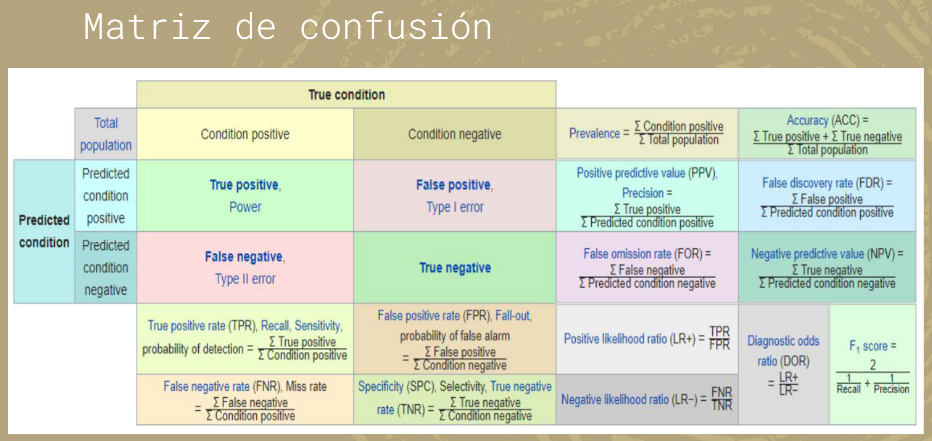

In [ ]:
confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Real,,
0,316,110
1,39,1054


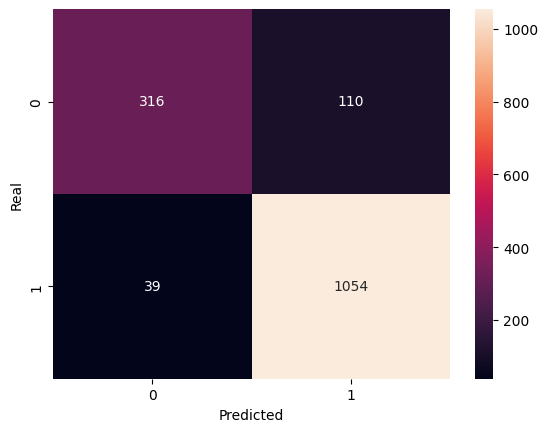

In [ ]:
#Matriz de confusión

data = {'Y_Real':  y_test,
        'Y_Prediccion':y_predict
        }

df = pd.DataFrame(data, columns=['Y_Real','Y_Prediccion'])
confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

## Paso 4. Entrenamiento de perceptron utilizando margen

In [ ]:
model2 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2',  alpha=0.0001)
model2.fit(X_train,y_train)

print("Precisión conjunto entrenamiento: %.2f%%" % (model2.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model2.score(X_test, y_test)*100.0))


Precisión conjunto entrenamiento: 77.48%
Precisión conjunto prueba: 77.49%


In [ ]:
model3 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2', alpha=0.000005)

model3.fit(X_train,y_train)

print("Precisión conjunto entrenamiento: %.2f%%" % (model3.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model3.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 94.38%
Precisión conjunto prueba: 90.06%


In [ ]:
model4 = Perceptron(max_iter=1000,  random_state=0, verbose=False,
                    penalty='l2', alpha=0.000001)
model4.fit(X_train,y_train)

print("Precisión conjunto entrenamiento: %.2f%%" % (model4.score(X_train, y_train)*100.0))
print("Precisión conjunto prueba: %.2f%%" % (model4.score(X_test, y_test)*100.0))

Precisión conjunto entrenamiento: 98.59%
Precisión conjunto prueba: 92.03%
